#### Loading the libraries

In [ ]:
pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import csv
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

#### Loading data and selecting necessary columns

In [ ]:
# Load the data from a tab-separated file into a pandas DataFrame
data = pd.read_csv('/content/drive/MyDrive/MSBA 315/amazon_reviews.txt', sep='\t')

# Drop the 'VERIFIED_PURCHASE' column from the data DataFrame
data = data.drop('VERIFIED_PURCHASE', axis=1)

# Select only the 'LABEL', 'RATING', and 'REVIEW_TEXT' columns of the data DataFrame
data = data[['LABEL', 'RATING', 'REVIEW_TEXT']]

# Calculate the length of each review in the 'REVIEW_TEXT' column and store it in a new 'REVIEW_LENGTH' column
data['REVIEW_LENGTH'] = data['REVIEW_TEXT'].apply(len)

#### Selecting the max features, using countvectorizer on REVIEW/TEXT and replacing Label 1 with 1 and Label 2 with 0

In [ ]:
# Use CountVectorizer to convert the 'REVIEW_TEXT' column into a bag of words representation
vectorizer = CountVectorizer(max_features=500)
X = vectorizer.fit_transform(data['REVIEW_TEXT'])

# Convert the bag of words representation into a DataFrame with proper column names
bag_of_words_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Replace the 'REVIEW_TEXT' column in the original DataFrame with the new bag of words columns
data = pd.concat([data.drop('REVIEW_TEXT', axis=1), bag_of_words_df], axis=1)

# Convert values in the 'LABEL' column, mapping __label1__ to 1 and __label2__ to 0
data['LABEL'] = data['LABEL'].map({'__label1__': 1, '__label2__': 0})

#### Using Lazy Predict library to test all classification models

In [ ]:
# Split the data into train and test sets
X = data.drop('LABEL', axis=1)
y = data['LABEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train multiple classifiers with lazypredict
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Print the results
print(models)

  0%|          | 0/29 [00:04<?, ?it/s]


KeyboardInterrupt: ignored

#### Using GridSearchCV to find the best hyperparameters

In [ ]:
# Split the data into train and test sets
X = data.drop('LABEL', axis=1)
y = data['LABEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LGBMClassifier model
lgbm = LGBMClassifier()

# Specify the hyperparameters and their possible values for the grid search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Initialize the grid search with cross-validation
grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the LGBMClassifier model with the best parameters
best_lgbm = LGBMClassifier(**best_params)
best_lgbm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_lgbm.predict(X_test)

# Evaluate the model using accuracy_score, precision_score, recall_score, and f1_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

KeyboardInterrupt: ignored

#### Using LGBM with the needed hyperparameters

In [ ]:
# Split the data into train and test sets
X = data.drop('LABEL', axis=1)
y = data['LABEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the rating and review length features using MinMaxScaler
scaler = MinMaxScaler()
X_train[['RATING', 'REVIEW_LENGTH']] = scaler.fit_transform(X_train[['RATING', 'REVIEW_LENGTH']])
X_test[['RATING', 'REVIEW_LENGTH']] = scaler.transform(X_test[['RATING', 'REVIEW_LENGTH']])

# Train a LightGBM model with the specified hyperparameters
lgbm = LGBMClassifier(learning_rate=0.1, max_depth=5, n_estimators=200)
lgbm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lgbm.predict(X_test)

# Evaluate the model using accuracy_score, precision_score, recall_score, and f1_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

Accuracy: 0.6805
Precision: 0.6833
Recall: 0.6813
F1 score: 0.6823


#### Confusion Matrix for the model

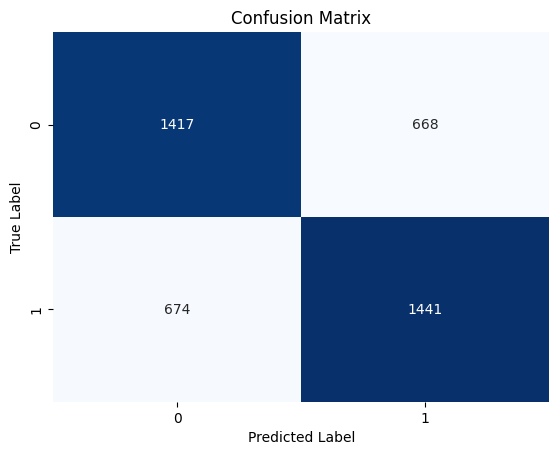

In [ ]:

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Saving the model

In [ ]:
# Save the trained model to disk using joblib
joblib.dump(lgbm, 'lgbm_model68.joblib')

['lgbm_model68.joblib']

###Labelling the data

####Loading the data and the model

In [ ]:
# Load the saved model
lgbm = joblib.load('/content/drive/MyDrive/MSBA 315/lgbm_model68.joblib')
data_updated = pd.read_csv('/content/drive/MyDrive/MSBA 315/updated_data (1).csv')

#### Selecting the necessary columns, creating the needed ones and filtering the data to avoid runtime crash

In [ ]:
# Create a new DataFrame with only the 'review/score' and 'review/text' columns from data_updated
data_labelling = data_updated[['review/score', 'review/text']]

# Calculate the length of each review in the 'review/text' column and store it in a new 'review_length' column
data_labelling['review_length'] = data_labelling['review/text'].apply(len)

# Filter out rows where the 'review_length' is greater than 16000
data_labelling = data_labelling[data_labelling['review_length'] <= 16000]

# Use sample() to randomly select 400000 rows from the filtered DataFrame
data_labelling = data_labelling.sample(n=400000, random_state=42)

####Scaling the numerical columns

In [ ]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Apply the scaler to the 'review/score' and 'review_length' columns of the data_labelling DataFrame
data_labelling[['review/score', 'review_length']] = scaler.fit_transform(data_labelling[['review/score', 'review_length']])

#### Using countVectorizer and the max features needed and adding the review/text column

In [ ]:
# Create a CountVectorizer object with a maximum of 500 features
vectorizer = CountVectorizer(max_features=500)

# Apply the CountVectorizer to the 'review/text' column of the data_labelling DataFrame
X = vectorizer.fit_transform(data_labelling['review/text'])

# Convert the resulting bag of words representation into a DataFrame with proper column names
bag_of_words_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Join the DataFrames based on their common index values
data = data_labelling.drop('review/text', axis=1).join(bag_of_words_df)

#### Getting probabilities and assigning a label column for our dataset, to get the fake and the real reviews

In [ ]:
# Predict the probabilities using the trained model
probas = lgbm.predict_proba(data)[:, 1]

# Create a new 'label' column based on the predicted probabilities
data['label'] = (probas >= 0.5).astype(int)

#### Selecting the needed columns and joining no indices to get the other columns that would be used in the next model

In [ ]:
# Select only the 'review/score', 'review_length', and 'label' columns of the data DataFrame
data = data[['review/score', 'review_length', 'label']]

# Join the 'Title', 'review/helpfulness', 'review/time', 'review/summary', 'review/text', 'authors', and 'publishedDate' columns from data_updated to the data DataFrame
data = data.join(data_updated[['Title', 'review/helpfulness', 'review/time', 'review/summary', 'review/text', 'authors', 'publishedDate']])

#### Dropping the 2 columns as they were used in the labelling process to avoid data leakage

In [ ]:
# Drop the 'review/score' and 'review_length' columns from the data DataFrame, and store the result in final_data
final_data = data.drop(['review/score', 'review_length'], axis=1)

NameError: ignored

####Loading the labelled data

In [ ]:
# Loading labelled data
labelled = pd.read_csv('/content/drive/MyDrive/MSBA 315/labeled_reviews.csv')

#### Dropping column that we do not need, and filtering the review/time according to the published date

In [ ]:
labelled = labelled.drop('preprocessed_text', axis = 1)
labelled = labelled.drop('review/text', axis = 1)

labelled = labelled[(labelled['review/time'] >= labelled['publishedDate'].min()) & (labelled['review/time'] <= labelled['publishedDate'].max())]
labelled['review/helpfulness'] = labelled['review/helpfulness'].str[0]
labelled['review/helpfulness'] = labelled['review/helpfulness'].astype(int)

labelled['review/time'] = pd.to_datetime(labelled['review/time'])
labelled['publishedDate'] = pd.to_datetime(labelled['publishedDate'])
# Extract year, month, and day from 'review/time' column and create new columns
labelled['review/time_year'] = labelled['review/time'].dt.year
labelled['review/time_month'] = labelled['review/time'].dt.month
labelled['review/time_day'] = labelled['review/time'].dt.day

# Extract year, month, and day from 'publishedDate' column and create new columns
labelled['publishedDate_year'] = labelled['publishedDate'].dt.year
labelled['publishedDate_month'] = labelled['publishedDate'].dt.month
labelled['publishedDate_day'] = labelled['publishedDate'].dt.day

# Calculate the difference in days between the two dates and store the result in a new column
labelled['difference'] = (labelled['publishedDate'] - labelled['review/time']).dt.days

# Discard the rows where the difference is negative
labelled = labelled[labelled['difference'] >= 0]

labelled = labelled.drop('review/time', axis = 1)
labelled = labelled.drop('publishedDate', axis = 1)

#### EDA

Vocabulary size: 35846
Most frequent words:
book: 29759
great: 18558
read: 15859
good: 12962
best: 6392
excellent: 5924
story: 5191
love: 4419
classic: 3687
wonderful: 3087


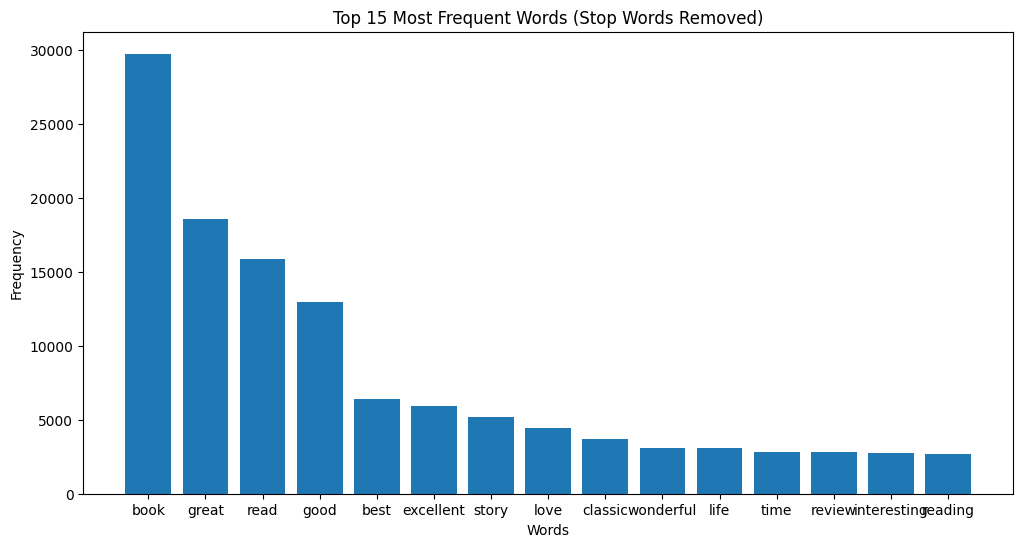

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# create a bag of words model with stop words removed
vectorizer = CountVectorizer(stop_words='english')
bag_of_words = vectorizer.fit_transform(train['review/summary'])

# print the vocabulary size
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")

# get the feature names and print the most frequent words
feature_names = vectorizer.get_feature_names_out()
word_frequencies = dict(zip(feature_names, bag_of_words.sum(axis=0).tolist()[0]))
sorted_words = sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)
print("Most frequent words:")
for word, freq in sorted_words[:10]:
    print(f"{word}: {freq}")

# plot the top 15 most frequent words
top_words = sorted_words[:15]
words, frequencies = zip(*top_words)

plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 15 Most Frequent Words (Stop Words Removed)')
plt.show()


The top 10 most frequent words in the review summaries, after excluding common stop words, are related to positive sentiments and general attributes of the books. It indicates that reviewers tend to express their opinions using words like "book", "great", "read", "good", "best", "excellent", "story", "love", "classic", and "wonderful".

This finding suggests that reviewers often have a favorable view of the books they review, and the reviews are likely to focus on the positive aspects of the books. The presence of words like "story" and "classic" hints that readers appreciate the narrative quality and timelessness of the books they review.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = train.copy()

# Sort the DataFrame by the 'review/time' column
df = df.sort_values('review/time_year')

# Compute the mean 'review/helpfulness' for each year
df_year = df.groupby(df['review/time_year'])['review/helpfulness'].mean()

# Plot the time series data
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_year.index, df_year.values, color='blue', alpha=0.5, marker='o', linestyle='--')
ax.set_xlabel('Year')
ax.set_ylabel('Average Helpfulness')
ax.set_title('Average Helpfulness of Reviews Across Years')

# Add a bar chart of the count of the titles
title_counts = df['Title'].groupby(df['review/time_year']).count()
ax2 = ax.twinx()
ax2.bar(title_counts.index, title_counts.values, color='orange', alpha=0.5, width=0.4)
ax2.set_ylabel('Number of Reviews')

plt.show()


### Basic Pipeline

#### Using CountVectorizer on the Title column

In [ ]:
# Create a CountVectorizer object with a maximum of 500 features
vectorizer = CountVectorizer(max_features=50)

# Apply the CountVectorizer to the 'Title' column of the data_labelling DataFrame
X = vectorizer.fit_transform(labelled['Title'])

# Convert the resulting bag of words representation into a DataFrame with proper column names
bag_of_words_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Join the DataFrames based on their common index values
labelled = labelled.drop('Title', axis=1).join(bag_of_words_df)

#### Using CountVectorizer on review/summary column

In [ ]:
# Create a CountVectorizer object with a maximum of 150 features
vectorizer = CountVectorizer(max_features=150)

# Apply the CountVectorizer to the 'review/summary' column of the X_train DataFrame
X = vectorizer.fit_transform(labelled['review/summary'])

# Convert the resulting bag of words representation into a DataFrame with proper column names
bag_of_words_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Rename the columns that were created from the 'review/summary' column
bag_of_words_df.columns = ['review/summary_' + col for col in bag_of_words_df.columns]

# Join the X_train and bag_of_words_df DataFrames based on their common index values
labelled = labelled.drop('review/summary', axis=1).join(bag_of_words_df)

#### Label Encoding the authors column

In [ ]:
#split data
labelled = labelled.dropna()

X = labelled.drop('label', axis=1)
y = labelled['label']

X_train, X_test, y_train , y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

####Labelling the authors in X_train

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the LabelEncoder to the 'authors' column
le.fit(X_train['authors'])

# Transform the 'authors' column using the LabelEncoder
X_train['authors_encoded'] = le.transform(X_train['authors'])

# Drop the original 'authors' column
X_train = X_train.drop('authors', axis=1)

#### Using minmaxscaler to scale numerical columns

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Define the columns to be scaled
columns_to_scale = ['review/helpfulness', 'review/time_year', 'review/time_month',
       'review/time_day', 'publishedDate_year', 'publishedDate_month',
       'publishedDate_day']

# Fit the scaler to the training set and transform the specified columns
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

#### Using the same preprocess steps on x_test. The steps decreased to encoding while developping the code

In [ ]:
def preprocess_data(X_test):

    # Fit the LabelEncoder to the 'authors' column
    le.fit(X_test['authors'])

    # Transform the 'authors' column using the fitted LabelEncoder
    X_test['authors_encoded'] = le.transform(X_test['authors'])

    # Drop the original 'authors' column
    X_test = X_test.drop('authors', axis=1)

    return X_test

In [ ]:
X_test = preprocess_data(X_test)

In [ ]:
# Transform the specified columns in the test set using the fitted scaler from the training set
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

### Trying out models

#### Using LogReg Model

Accuracy: 0.42
Precision: 0.29
Recall: 0.80
F1 Score: 0.43
AUC Score: 0.58


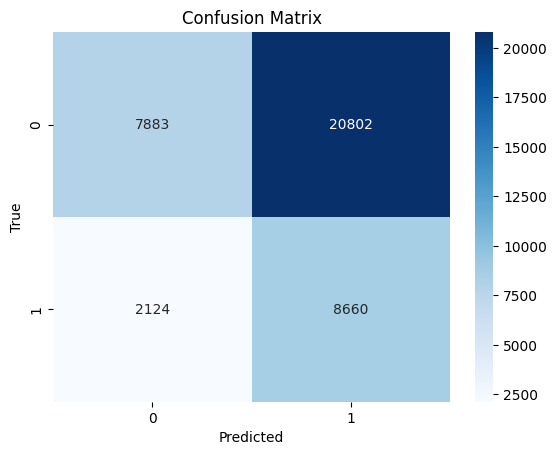

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

# Undersample the majority class to balance the classes
rus = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Fit a logistic regression model to the resampled training data
model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)

# Predict the target variable on the testing data
y_pred = model.predict(X_test)

# Compute and print the evaluation metrics
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('AUC Score: {:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

####Using LGBMClassifier

Accuracy: 0.59
Precision: 0.34
Recall: 0.52
F1 Score: 0.41
AUC Score: 0.60


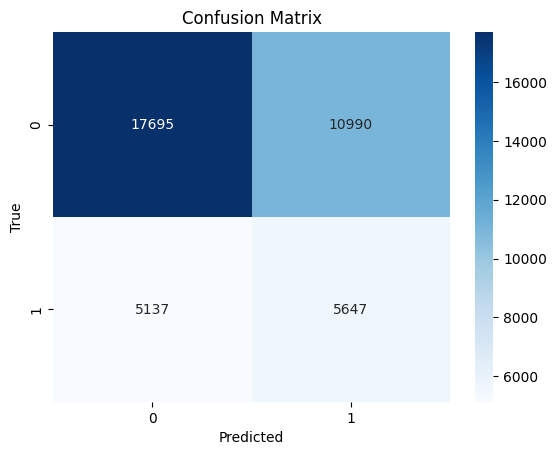

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

# Undersample the majority class to balance the classes
rus = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Fit a LightGBM classifier to the resampled training data
model = LGBMClassifier()
model.fit(X_train_resampled, y_train_resampled)

# Predict the target variable on the testing data
y_pred = model.predict(X_test)

# Compute and print the evaluation metrics
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('AUC Score: {:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### Using KNeighborsClassifier

Accuracy: 0.51
Precision: 0.27
Recall: 0.48
F1 Score: 0.35
AUC Score: 0.50


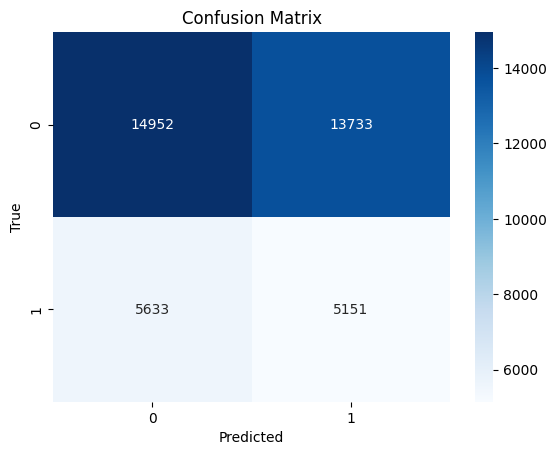

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

# Undersample the majority class to balance the classes
rus = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Fit a KNN classifier to the resampled training data
model = KNeighborsClassifier()
model.fit(X_train_resampled, y_train_resampled)

# Predict the target variable on the testing data
y_pred = model.predict(X_test)

# Compute and print the evaluation metrics
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('AUC Score: {:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### Using XGBClassifier

Accuracy: 0.58
Precision: 0.33
Recall: 0.51
F1 Score: 0.40
AUC Score: 0.58


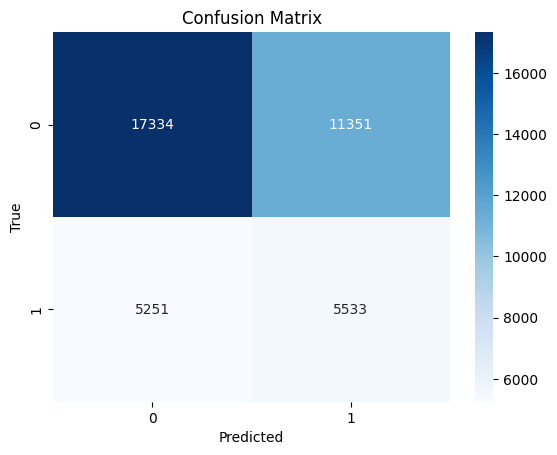

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

# Undersample the majority class to balance the classes
rus = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Fit an XGBoost classifier to the resampled training data
model = XGBClassifier()
model.fit(X_train_resampled, y_train_resampled)

# Predict the target variable on the testing data
y_pred = model.predict(X_test)

# Compute and print the evaluation metrics
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('AUC Score: {:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### Using RandomForestClassifier

Accuracy: 0.58
Precision: 0.33
Recall: 0.50
F1 Score: 0.39
AUC Score: 0.58


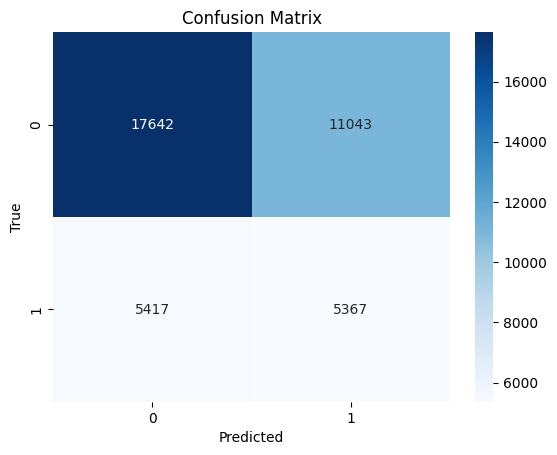

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

# Undersample the majority class to balance the classes
rus = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Fit a Random Forest classifier to the resampled training data
model = RandomForestClassifier()
model.fit(X_train_resampled, y_train_resampled)

# Predict the target variable on the testing data
y_pred = model.predict(X_test)

# Compute and print the evaluation metrics
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('AUC Score: {:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### Using MLPClassifier

Accuracy: 0.73
Precision: 0.41
Recall: 0.01
F1 Score: 0.01
AUC Score: 0.54


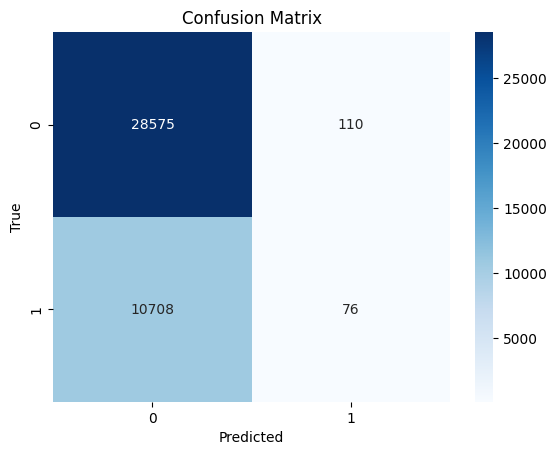

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns


# Fit a neural network classifier to the resampled training data
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
model.fit(X_train, y_train)

# Predict the target variable on the testing data
y_pred = model.predict(X_test)

# Compute and print the evaluation metrics
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('AUC Score: {:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### Trying the best random state for LGBMClassifier

Best Random State: 28
Accuracy: 0.60
Precision: 0.34
Recall: 0.52
F1 Score: 0.41
AUC Score: 0.60


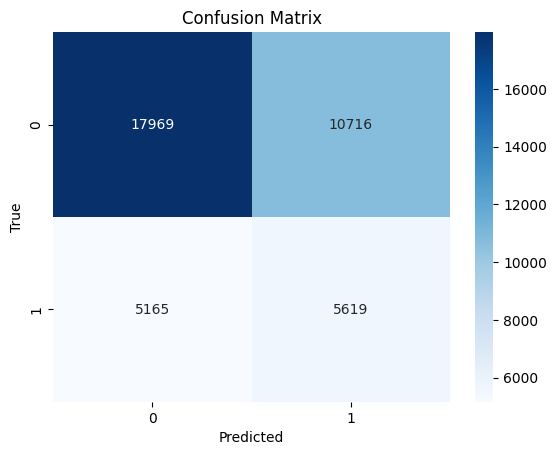

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

best_acc = 0
best_model = None
best_state = None

# Try different random states and select the model with the highest accuracy
for state in range(50):
    # Undersample the majority class to balance the classes
    rus = RandomUnderSampler(random_state=state)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

    # Fit a LightGBM classifier to the resampled training data
    model = LGBMClassifier()
    model.fit(X_train_resampled, y_train_resampled)

    # Predict the target variable on the testing data
    y_pred = model.predict(X_test)

    # Compute the accuracy of the model
    acc = accuracy_score(y_test, y_pred)

    # If the accuracy of the current model is higher than the previous best, save it as the new best model
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_state = state

# Use the best model to predict the target variable on the testing data
y_pred = best_model.predict(X_test)

# Compute and print the evaluation metrics
print('Best Random State:', best_state)
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('AUC Score: {:.2f}'.format(roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


####LGBMClassifier after dropping the authors column

Accuracy: 0.60
Precision: 0.35
Recall: 0.52
F1 Score: 0.42
AUC Score: 0.61


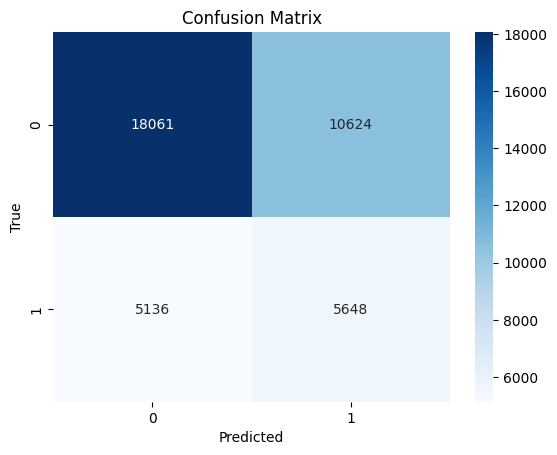

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

# Undersample the majority class to balance the classes
rus = RandomUnderSampler(random_state=28)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

X_train_resampled = X_train_resampled.drop('authors', axis = 1)
X_test = X_test.drop('authors', axis = 1)

# Fit a LightGBM classifier to the resampled training data
model = LGBMClassifier()
model.fit(X_train_resampled, y_train_resampled)

# Predict the target variable on the testing data
y_pred = model.predict(X_test)

# Compute and print the evaluation metrics
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('AUC Score: {:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### Getting the best 100 features for LGBMclassifier

In [ ]:
#split data
labelled_eng = labelled.dropna()

# Create a CountVectorizer object with a maximum of 500 features
vectorizer = CountVectorizer(max_features=50, stop_words='english')

# Apply the CountVectorizer to the 'Title' column of the data_labelling DataFrame
X = vectorizer.fit_transform(labelled_eng['Title'])

# Convert the resulting bag of words representation into a DataFrame with proper column names
bag_of_words_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Join the DataFrames based on their common index values
labelled_eng = labelled_eng.drop('Title', axis=1).join(bag_of_words_df)


# Create a CountVectorizer object with a maximum of 150 features
vectorizer = CountVectorizer(max_features=150, stop_words='english')

# Apply the CountVectorizer to the 'review/summary' column of the X_train DataFrame
X = vectorizer.fit_transform(labelled_eng['review/summary'])

# Convert the resulting bag of words representation into a DataFrame with proper column names
bag_of_words_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Rename the columns that were created from the 'review/summary' column
bag_of_words_df.columns = ['review/summary_' + col for col in bag_of_words_df.columns]

# Join the X_train and bag_of_words_df DataFrames based on their common index values
labelled_eng = labelled_eng.drop('review/summary', axis=1).join(bag_of_words_df)


X = labelled_eng.drop('label', axis=1)
y = labelled_eng['label']

X_train, X_test, y_train , y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

Accuracy: 0.73
Precision: 0.60
Recall: 0.02
F1 Score: 0.03
AUC Score: 0.61


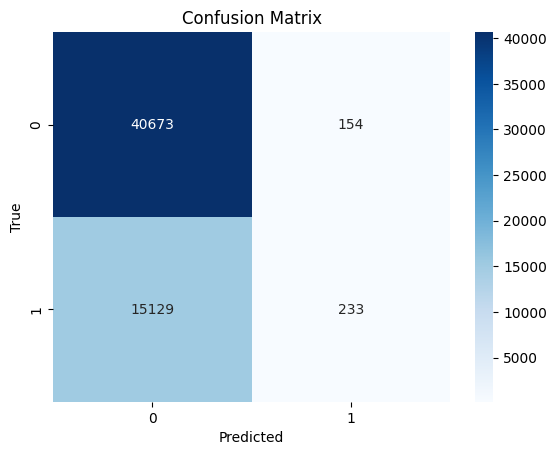

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

X_train = X_train.drop('authors', axis = 1)
X_test = X_test.drop('authors', axis = 1)

# Undersample the majority class to balance the classes
rus = RandomUnderSampler(random_state=28)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Fit a LightGBM classifier to the resampled training data
model = LGBMClassifier()
model.fit(X_train_resampled, y_train_resampled)

# Get the feature importances from the trained model
importance = model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importance)[::-1]

# Get the 100 most important features
top_features = X_train.columns[indices][:100]

# Select only the top 100 features from the training and testing data
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Fit a LightGBM classifier to the resampled training data with the top 100 features
model_top = LGBMClassifier()
model_top.fit(X_train_top, y_train)

# Predict the target variable on the testing data with the top 100 features
y_pred = model_top.predict(X_test_top)

# Compute and print the evaluation metrics
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('AUC Score: {:.2f}'.format(roc_auc_score(y_test, model_top.predict_proba(X_test_top)[:,1])))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Getting the best 10 features for LGBMclassifier

Accuracy: 0.73
Precision: 0.61
Recall: 0.02
F1 Score: 0.04
AUC Score: 0.61


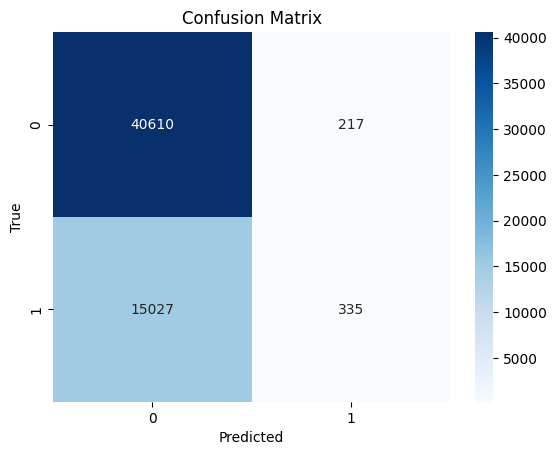

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

X_train = X_train.drop('authors', axis = 1)
X_test = X_test.drop('authors', axis = 1)

# Undersample the majority class to balance the classes
rus = RandomUnderSampler(random_state=28)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Fit a LightGBM classifier to the resampled training data
model = LGBMClassifier()
model.fit(X_train_resampled, y_train_resampled)

# Get the feature importances from the trained model
importance = model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importance)[::-1]

# Get the 100 most important features
top_features = X_train.columns[indices][:10]

# Select only the top 100 features from the training and testing data
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Fit a LightGBM classifier to the resampled training data with the top 100 features
model_top = LGBMClassifier()
model_top.fit(X_train_top, y_train)

# Predict the target variable on the testing data with the top 100 features
y_pred = model_top.predict(X_test_top)

# Compute and print the evaluation metrics
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('AUC Score: {:.2f}'.format(roc_auc_score(y_test, model_top.predict_proba(X_test_top)[:,1])))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
top_features

Index(['publishedDate_day', 'publishedDate_month', 'publishedDate_year',
       'review/time_day', 'review/time_year', 'review/time_month',
       'review/helpfulness', 'love', 'review/summary_book', 'death'],
      dtype='object')

#### Using the LGBMClassifier with the difference column that was added above in the code at the time of the trial

In [ ]:
#split data
labelled_eng = labelled.dropna()

# Create a CountVectorizer object with a maximum of 500 features
vectorizer = CountVectorizer(max_features=50, stop_words='english')

# Apply the CountVectorizer to the 'Title' column of the data_labelling DataFrame
X = vectorizer.fit_transform(labelled_eng['Title'])

# Convert the resulting bag of words representation into a DataFrame with proper column names
bag_of_words_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Join the DataFrames based on their common index values
labelled_eng = labelled_eng.drop('Title', axis=1).join(bag_of_words_df)

# Create a CountVectorizer object with a maximum of 150 features
vectorizer = CountVectorizer(max_features=150, stop_words='english')

# Apply the CountVectorizer to the 'review/summary' column of the X_train DataFrame
X = vectorizer.fit_transform(labelled_eng['review/summary'])

# Convert the resulting bag of words representation into a DataFrame with proper column names
bag_of_words_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Rename the columns that were created from the 'review/summary' column
bag_of_words_df.columns = ['review/summary_' + col for col in bag_of_words_df.columns]

# Join the X_train and bag_of_words_df DataFrames based on their common index values
labelled_eng = labelled_eng.drop('review/summary', axis=1).join(bag_of_words_df)

In [ ]:
X = labelled_eng.drop('label', axis=1)
y = labelled_eng['label']

In [ ]:
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

Accuracy: 0.76
Precision: 0.50
Recall: 0.00
F1 Score: 0.01
AUC Score: 0.59


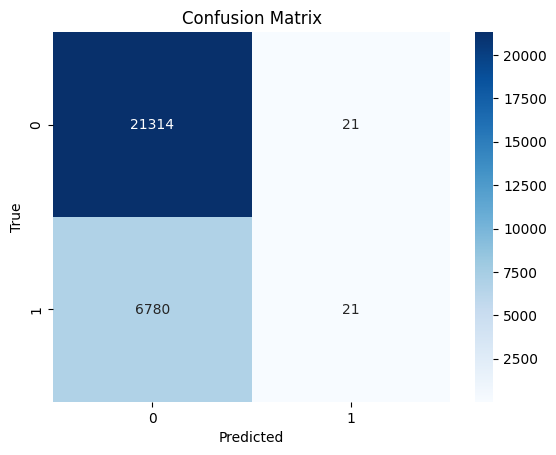

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

X_train = X_train.drop('authors', axis = 1)
X_test = X_test.drop('authors', axis = 1)

# Undersample the majority class to balance the classes
rus = RandomUnderSampler(random_state=28)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Fit a LightGBM classifier to the resampled training data
model = LGBMClassifier()
model.fit(X_train_resampled, y_train_resampled)

# Get the feature importances from the trained model
importance = model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importance)[::-1]

# Get the 100 most important features
top_features = X_train.columns[indices][:10]

# Select only the top 100 features from the training and testing data
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Fit a LightGBM classifier to the resampled training data with the top 100 features
model_top = LGBMClassifier()
model_top.fit(X_train_top, y_train)

# Predict the target variable on the testing data with the top 100 features
y_pred = model_top.predict(X_test_top)

# Compute and print the evaluation metrics
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('AUC Score: {:.2f}'.format(roc_auc_score(y_test, model_top.predict_proba(X_test_top)[:,1])))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### Using GridSearchCV with the 10 most important features

Accuracy: 0.76
Precision: 0.50
Recall: 0.00
F1 Score: 0.00
AUC Score: 0.59


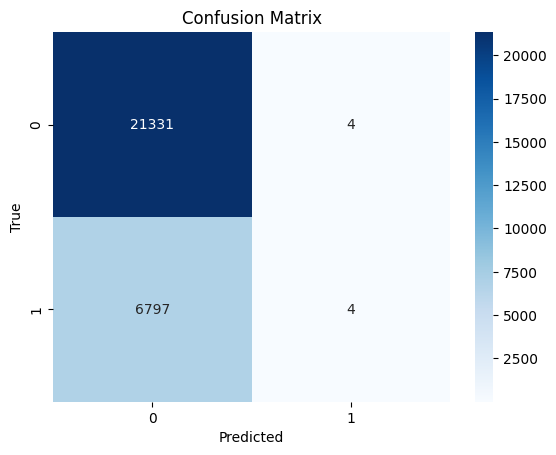

In [ ]:
from sklearn.model_selection import GridSearchCV

X_train = X_train.drop('authors', axis = 1)
X_test = X_test.drop('authors', axis = 1)

# Undersample the majority class to balance the classes
rus = RandomUnderSampler(random_state=28)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Fit a LightGBM classifier to the resampled training data
model = LGBMClassifier()
model.fit(X_train_resampled, y_train_resampled)

# Get the feature importances from the trained model
importance = model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importance)[::-1]

# Get the 100 most important features
top_features = X_train.columns[indices][:10]

# Select only the top 100 features from the training and testing data
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Define the parameter grid for grid search
param_grid = {'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 7], 'n_estimators': [100, 500, 1000]}

# Instantiate a GridSearchCV object
grid_search = GridSearchCV(LGBMClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search object to the resampled training data with the top 100 features
grid_search.fit(X_train_top, y_train)

# Get the best estimator from the grid search
model_top = grid_search.best_estimator_

# Predict the target variable on the testing data with the top 100 features
y_pred = model_top.predict(X_test_top)

# Compute and print the evaluation metrics
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred)))
print('AUC Score: {:.2f}'.format(roc_auc_score(y_test, model_top.predict_proba(X_test_top)[:,1])))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
